# TFG - Fórmula 1 - ML

Autor: Manuel Ventura Pacheco

Creación de una NN que nos premita hacer clasificación sobre el dataset que hemos preparado. En este caso utilizaremos la capa *lookup* de Tensorflow.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, Dropout, Input, Flatten, BatchNormalization, concatenate, AlphaDropout, StringLookup

from google.colab import drive
import joblib

## Leer data

In [ ]:
read_dir = '/content/drive/MyDrive/Universidad/TFG/data_ready/'
save_dir = '/content/drive/MyDrive/Universidad/TFG/models/'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(read_dir+'LEARNING_DF_NORMAL.csv')
drivers = pd.read_csv(read_dir+'drivers.csv', na_values=["\\N"], parse_dates=['dob'])
drivers['number'] = drivers['number'].astype('Int64')
circuits = pd.read_csv(read_dir+'circuits.csv', na_values=["\\N"])
constructors = pd.read_csv(read_dir+'constructors.csv', na_values=["\\N"])
date_parse_list = ['date', 'fp1_date', 'fp2_date', 'fp3_date', 'quali_date', 'sprint_date']
races = pd.read_csv(read_dir+'races.csv', na_values=["\\N"], parse_dates=date_parse_list)

## Preparar data

In [ ]:
df = df.loc[df['year'] >= 2000].copy()

# Clipping maximus on grid and position
df['grid'] = df['grid'].clip(upper=20)
df['position'] = df['position'].clip(upper=20)

# Add strings to df
df = df.merge(drivers[['driverId','driverRef']], how='inner', on='driverId')
df = df.merge(constructors[['constructorId','constructorRef']], how='inner', on='constructorId')
df = df.merge(circuits[['circuitId','circuitRef']], how='inner', on='circuitId')

# Position to one-hot
one_hot = pd.get_dummies(df['position'], prefix='position')
df = df.drop('position',axis = 1)
df = df.join(one_hot)

# Fit columns with scaler
scaler = MinMaxScaler(feature_range=(-1,1))
columns_to_scale = ['grid', 'year', 'round', 'age',	'experience', 'driversPointsBeforeRace', 'constPointsBeforeRace']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Remove columns with numeric Ids
df = df.drop(['driverId', 'constructorId', 'circuitId'], axis=1)

# Prepare inputs for ML
y = df.iloc[:,15:35].copy()
drivers = df['driverRef']
constructors = df['constructorRef']
circuits = df['circuitRef']
X = df.drop(['driverRef', 'constructorRef', 'circuitRef'], axis=1)
X = X.drop(X.iloc[:,12:32], axis = 1)

# Get vocabulary for embeddings
driver_refs = list(set(drivers))
constructor_refs = list(set(constructors))
circuit_refs = list(set(circuits))

# Moddel parameters dependant from input size
N_DRIVERS = len(driver_refs) + 1
N_CONSTRUCTORS = len(constructor_refs) + 1
N_CIRCUITS = len(circuit_refs) + 1
N_NUMERICS = X.shape[1]

# Crear modelo

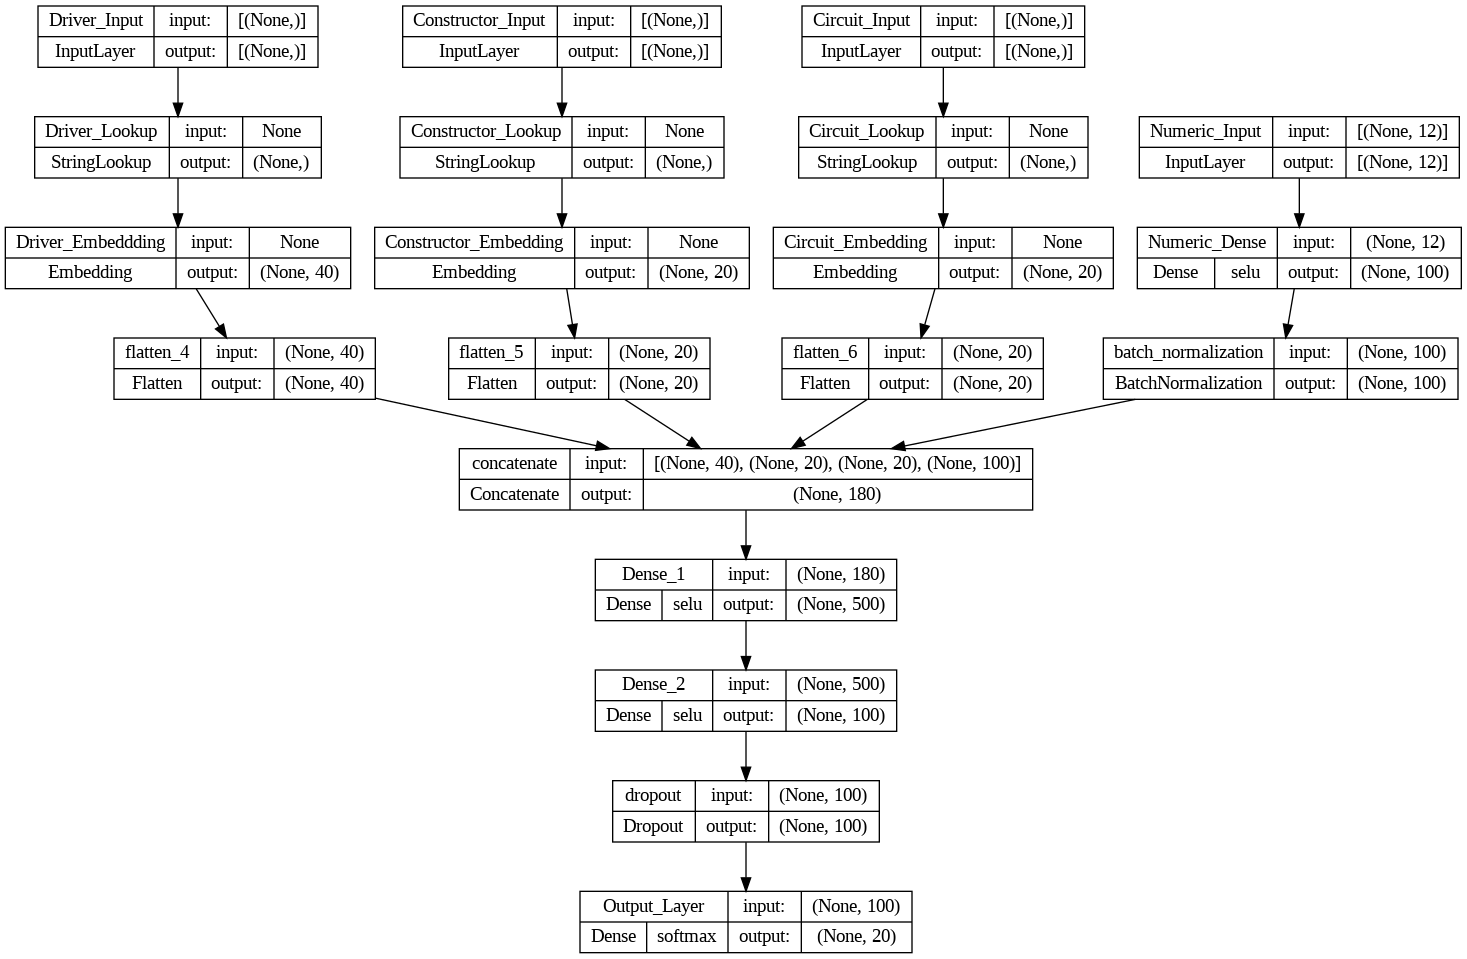

In [ ]:
activation_function = 'selu'
weight_initializer = 'lecun_uniform'

driver_lookup = StringLookup(name='Driver_Lookup')
driver_lookup.adapt(driver_refs)

driver_input = Input(shape=[], dtype=tf.string, name='Driver_Input')

driver_conv = driver_lookup(driver_input)

driver_embedding = Embedding(N_DRIVERS,
                             40,
                             input_length=1,
                             name='Driver_Embeddding')(driver_conv)

driver_flatten = Flatten()(driver_embedding)





constructor_lookup = StringLookup(name='Constructor_Lookup')
constructor_lookup.adapt(constructor_refs)

constructor_input = Input(shape=[], dtype=tf.string, name='Constructor_Input')

constructor_conv = constructor_lookup(constructor_input)

constructor_embedding = Embedding(N_CONSTRUCTORS,
                                  20,
                                  input_length=1,
                                  name='Constructor_Embedding')(constructor_conv)

constructor_flatten = Flatten()(constructor_embedding)






circuit_lookup = StringLookup(name='Circuit_Lookup')
circuit_lookup.adapt(circuit_refs)

circuit_input = Input(shape=[], dtype=tf.string, name='Circuit_Input')

circuit_conv = circuit_lookup(circuit_input)

circuit_embedding = Embedding(N_CIRCUITS,
                              20,
                              input_length=1,
                              name='Circuit_Embedding')(circuit_conv)

circuit_flatten = Flatten()(circuit_embedding)









numeric_inputs = Input(shape=(N_NUMERICS,),
                       name='Numeric_Input')

numeric_dense = Dense(100,
                      activation=activation_function,
                      kernel_initializer=weight_initializer,
                      name='Numeric_Dense')(numeric_inputs)

numeric_normalization = BatchNormalization()(numeric_dense)





concat_inputs = concatenate([driver_flatten, constructor_flatten, circuit_flatten, numeric_normalization])








dense_1 = Dense(500,
                activation=activation_function,
                kernel_initializer=weight_initializer,
                name='Dense_1')(concat_inputs)

dense_2 = Dense(100,
                activation=activation_function,
                kernel_initializer=weight_initializer,
                name='Dense_2')(dense_1)

dropout_1 = Dropout(rate=0.3)(dense_2)

out_layer = Dense(20,
                  activation='softmax',
                  kernel_initializer='glorot_uniform',
                  name='Output_Layer')(dropout_1)



model = keras.models.Model(inputs=[driver_input, constructor_input, circuit_input, numeric_inputs],
                           outputs=out_layer)


keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_activations=True)

Creamos optimizador, callbackcs, ...

In [ ]:
optim = keras.optimizers.Nadam(learning_rate=0.001)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                         patience=200)

Entrenar el modelo:

In [ ]:
history = model.fit([drivers, constructors, circuits, X],
                    y,
                    batch_size=64,
                    epochs=3000,
                    shuffle = True,
                    callbacks=[callback])

Epoch 1/3000
145/145 [==============================] - 1s 9ms/step - loss: 0.1612 - accuracy: 0.9489
Epoch 2/3000
145/145 [==============================] - 2s 14ms/step - loss: 0.1750 - accuracy: 0.9425
Epoch 3/3000
145/145 [==============================] - 2s 14ms/step - loss: 0.1778 - accuracy: 0.9430
Epoch 4/3000
145/145 [==============================] - 1s 9ms/step - loss: 0.1821 - accuracy: 0.9388
Epoch 5/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.1712 - accuracy: 0.9418
Epoch 6/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.1708 - accuracy: 0.9418
Epoch 7/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.1626 - accuracy: 0.9465
Epoch 8/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.1748 - accuracy: 0.9395
Epoch 9/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.1502 - accuracy: 0.9477
Epoch 10/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.1

Guardar modelo:

In [ ]:
model.save(save_dir+'nn_model_categorical', save_format='tf')
joblib.dump(scaler, save_dir+'minmaxscaler_categorical.pkl')

['/content/drive/MyDrive/Universidad/TFG/models/minmaxscaler_categorical.pkl']

Ilustrar pérdida durante entrenamiento.

<Axes: >

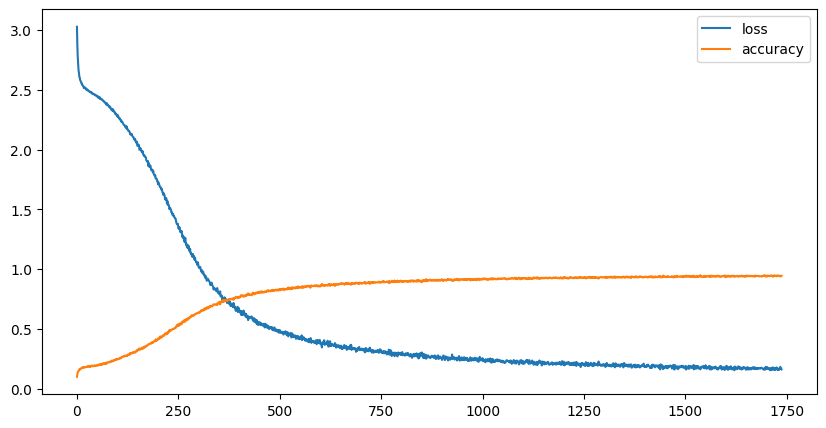

In [ ]:
pd.DataFrame({'loss': history.history['loss'],
              'accuracy': history.history['accuracy']}).plot(figsize=(10,5))